In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_|VISIBLE_DEVICES"]="0"

In [3]:
import numpy as np
import time

import matplotlib
import matplotlib.pyplot as plt
import colorcet
import seaborn as sns
import skimage.filters
from tqdm import tqdm

In [4]:
from wassersteinwormhole import Wormhole

In [5]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import jax

import ott
from ott import problems
from ott.geometry import geometry, pointcloud, epsilon_scheduler
from ott.solvers import linear, quadratic
from ott.solvers.linear import acceleration, sinkhorn, sinkhorn_lr
from ott.tools.sinkhorn_divergence import sinkhorn_divergence

# Load MNIST data

In [6]:
import tensorflow.keras.datasets
mnist = tensorflow.keras.datasets.mnist

(image_train, label_train), (image_test, label_test) = mnist.load_data()

2024-03-25 12:25:26.647395: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
thresh = skimage.filters.threshold_otsu(image_train.reshape([-1]))

In [8]:
pc_train = [np.stack(np.where(image>thresh), axis = 1) for image in image_train]
pc_test = [np.stack(np.where(image>thresh), axis = 1) for image in image_test]


## Show some examples

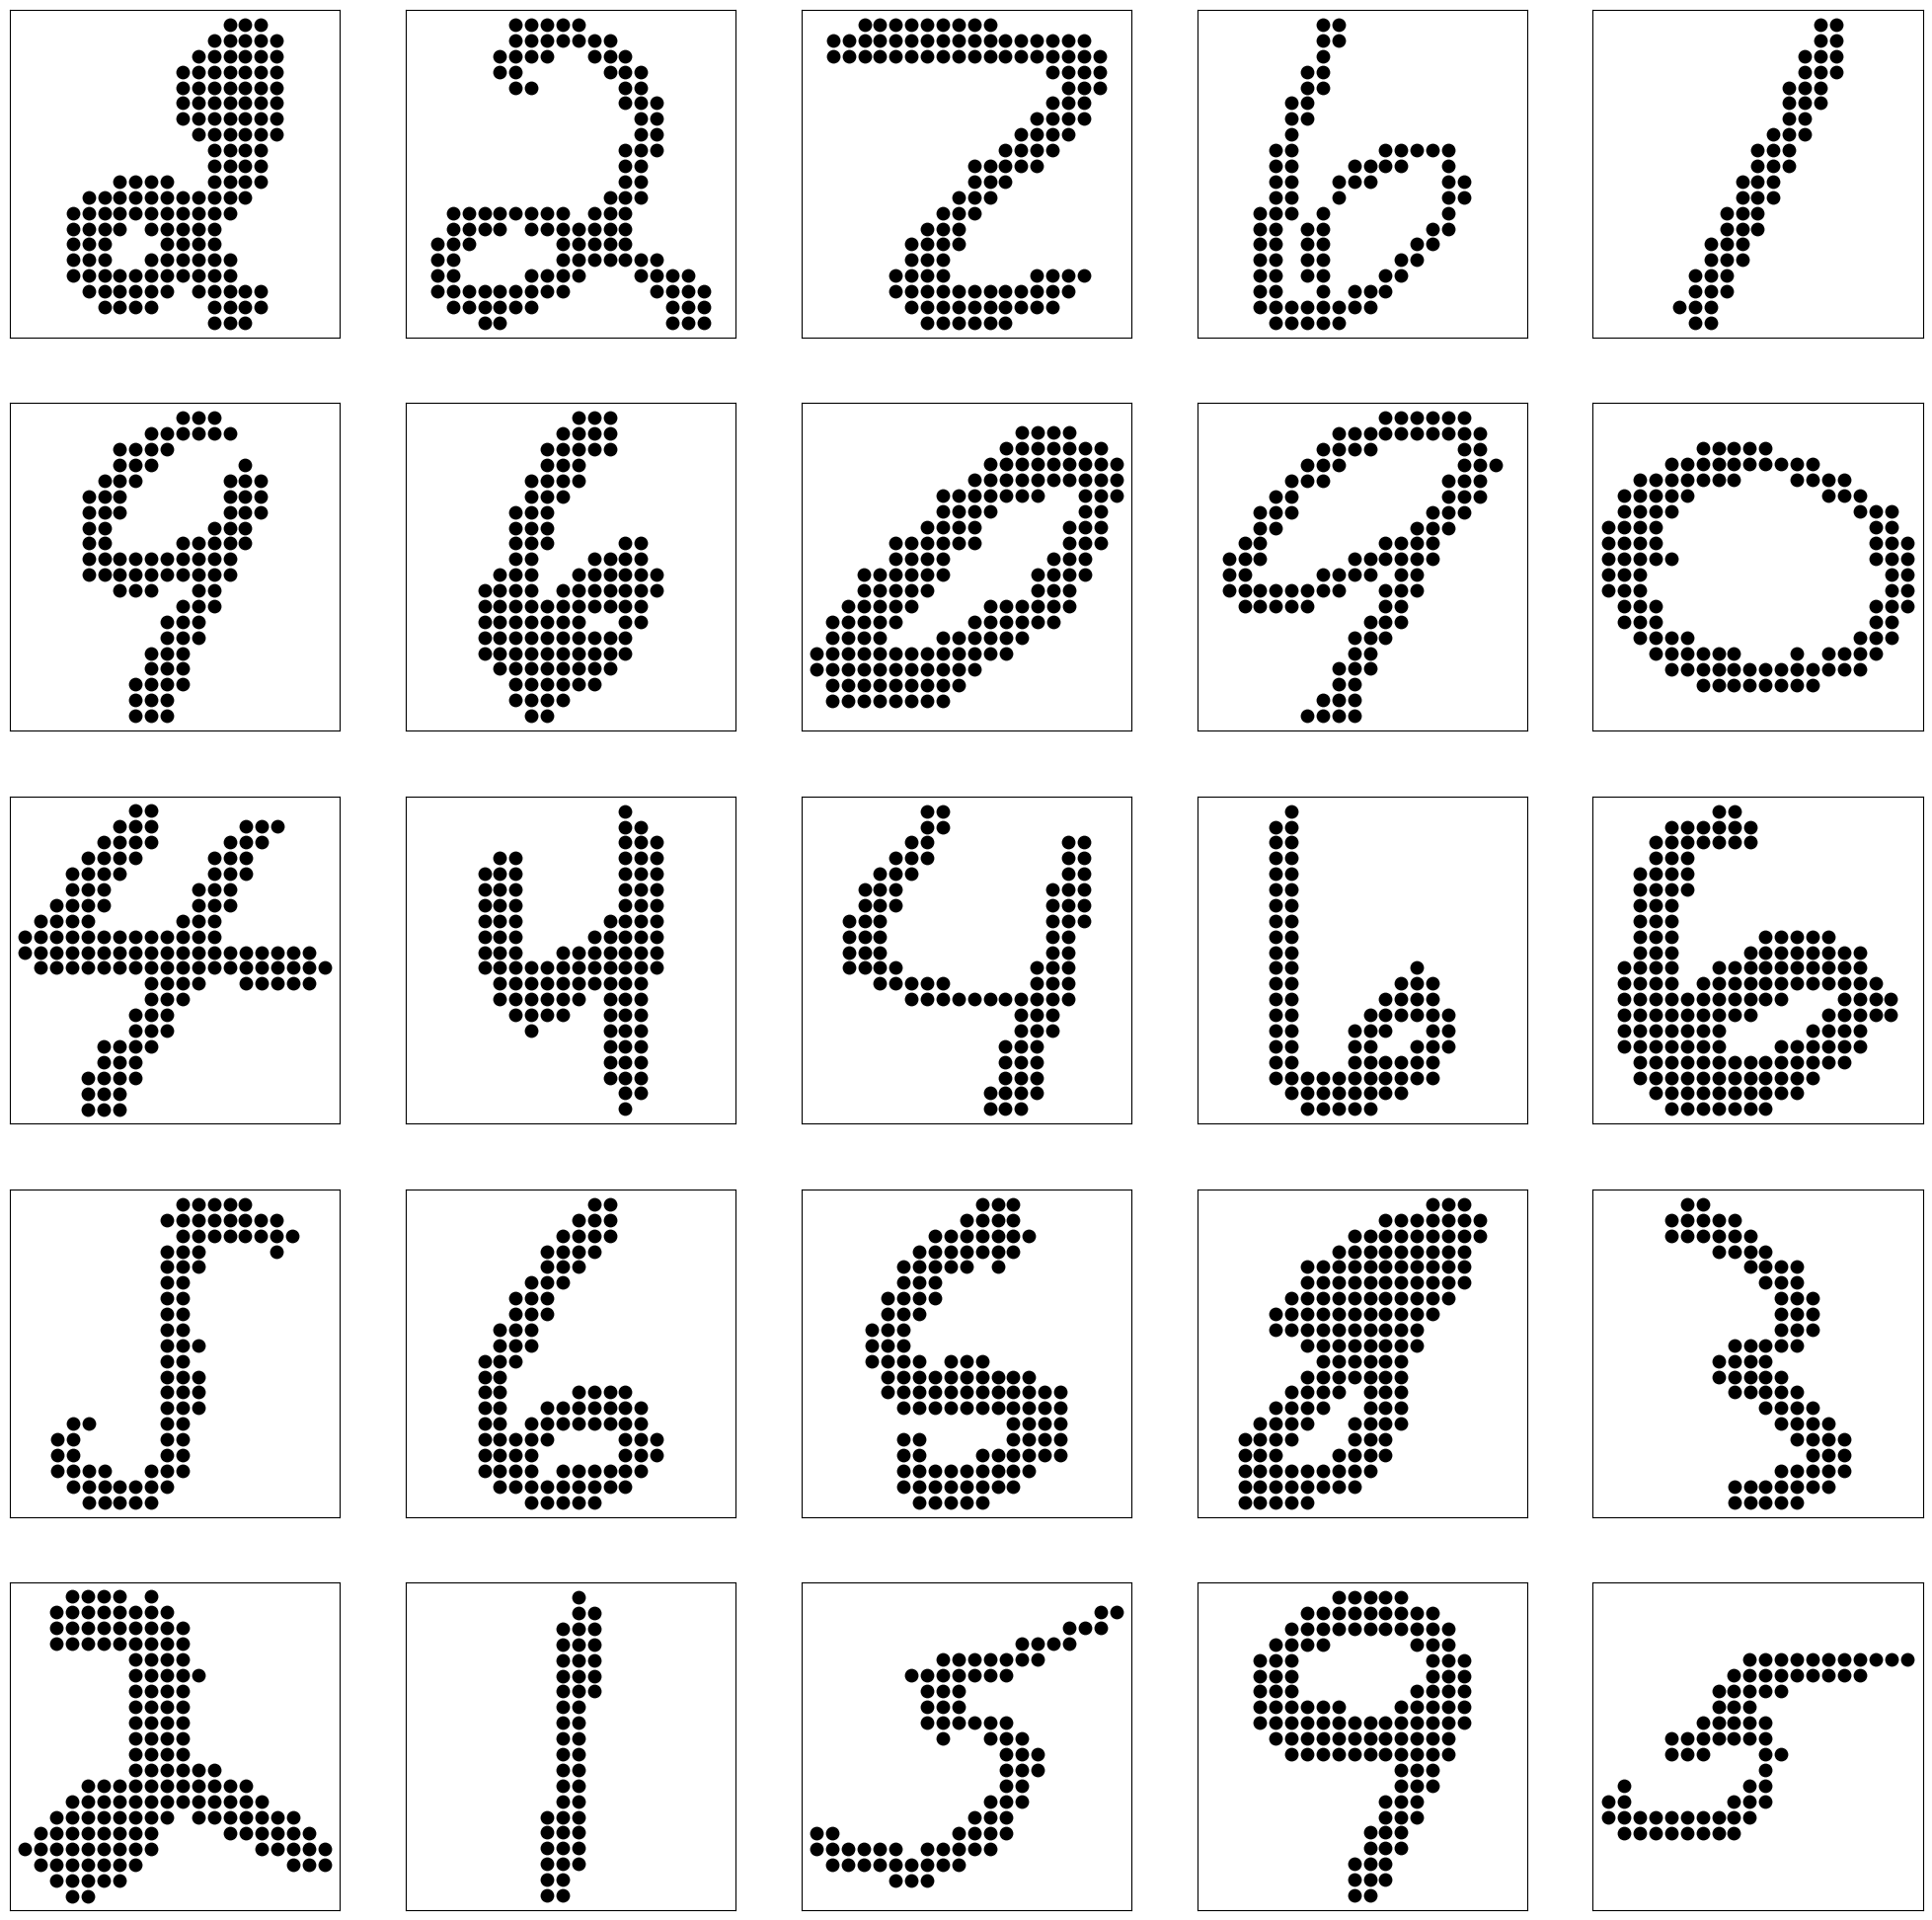

In [9]:
fig = plt.figure(figsize = (25,25))
for _ in range(25):
    ind = np.random.choice(np.arange(len(pc_train)))
    plt.subplot(5,5,1+_)
    plt.scatter(pc_train[ind][:, 1], -pc_train[ind][:, 0], c = 'black', s = 80)
    plt.xticks([])
    plt.yticks([])
    plt.axis('equal')
plt.show()

# Time-Trails

Create subsampled datasets with 100, 300, 1000, 5000, 10000, 30000, 50000 samples each

In [10]:
scale_sizes = [100, 300, 1000, 5000, 10000, 30000, 50000]

scale_inds = []
for size in scale_sizes:
    scale_inds.append(np.random.choice(np.arange(image_train.shape[0]), size, replace = False))

We will now measure how long it takes for each method to approximate the pairwise wasserstein distance for each dataset scale

## Wormhole

In [27]:
wormhole_times = []

In [28]:
def wormhole_func(pc): 
    WormholeModel = Wormhole(point_clouds = pc)
    WormholeModel.train()
    embeddings = WormholeModel.encode(WormholeModel.point_clouds, WormholeModel.masks)
    return(embeddings)

In [29]:
run_out = False
for inds in scale_inds:
    
    if(run_out):
         wormhole_times.append(18000)
    else:
        pc_scale = [pc_train[ind] for ind in inds]
        
        t_start = time.time()
        try:
            emb = wormhole_func(pc_scale)
        except TimeoutError:
            print("Run out of time")
            run_out = True
            
        t_ends = time.time()
        wormhole_times.append(t_ends - t_start)

 enc_loss: 1.080e-05 dec_loss: -4.320e-05 enc_corr: 0.996: 100%|██████████| 10000/10000 [04:32<00:00, 36.74it/s]
 enc_loss: 2.002e-05 dec_loss: 6.202e-05 enc_corr: 0.991: 100%|██████████| 10000/10000 [05:12<00:00, 32.01it/s]
 enc_loss: 2.988e-05 dec_loss: 3.117e-04 enc_corr: 0.986: 100%|██████████| 10000/10000 [05:35<00:00, 29.82it/s]
 enc_loss: 3.012e-05 dec_loss: 8.820e-04 enc_corr: 0.984: 100%|██████████| 10000/10000 [05:58<00:00, 27.88it/s]
 enc_loss: 2.685e-05 dec_loss: 8.088e-04 enc_corr: 0.987: 100%|██████████| 10000/10000 [06:18<00:00, 26.41it/s]
 enc_loss: 3.646e-05 dec_loss: 9.908e-04 enc_corr: 0.987: 100%|██████████| 10000/10000 [06:59<00:00, 23.85it/s]
 enc_loss: 3.216e-05 dec_loss: 1.064e-03 enc_corr: 0.986: 100%|██████████| 10000/10000 [06:37<00:00, 25.14it/s]


## Full Sinkhorn

In [12]:
def S2(x, y, eps, lse_mode = False):
    x,a = x[0], x[1]
    y,b = y[0], y[1]
        
    ot_solve_xy = linear.solve(
        ott.geometry.pointcloud.PointCloud(x, y, cost_fn=None, epsilon = eps),
        a = a,
        b = b,
        lse_mode=lse_mode,
        min_iterations=0,
        max_iterations=100)

    ot_solve_xx = linear.solve(
    ott.geometry.pointcloud.PointCloud(x, x, cost_fn=None, epsilon = eps),
    a = a,
    b = a,
    lse_mode=lse_mode,
    min_iterations=0,
    max_iterations=100)
    
    ot_solve_yy = linear.solve(
    ott.geometry.pointcloud.PointCloud(y, y, cost_fn=None, epsilon = eps),
    a = b,
    b = b,
    lse_mode=lse_mode,
    min_iterations=0,
    max_iterations=100)
    return(ot_solve_xy.reg_ot_cost - 0.5 * ot_solve_xx.reg_ot_cost - 0.5 * ot_solve_yy.reg_ot_cost)

jit_s2 = jax.jit(jax.vmap(S2, (0, 0, None, None), 0), static_argnums=[2,3])   
        

In [13]:
def normalize_pointclouds(point_clouds):
    min_val = np.min([pc.min() for pc in point_clouds])
    max_val = np.max([pc.max() for pc in point_clouds])
    
    return([2*(pc-min_val)/(max_val-min_val)-1 for pc in point_clouds])
    
def pad_pointclouds(point_clouds, max_shape = -1):
    if(max_shape == -1):
        max_shape = np.max([pc.shape[0] for pc in point_clouds])+1
    else:
        max_shape = max_shape + 1
    weight_vec = np.asarray([np.concatenate((np.ones(pc.shape[0]), np.zeros(max_shape - pc.shape[0])), axis = 0) for pc in point_clouds])
    point_clouds_pad = np.asarray([np.concatenate([pc, np.zeros([max_shape - pc.shape[0], pc.shape[-1]])], axis = 0) for pc in point_clouds])
    return(point_clouds_pad[:, :-1].astype('float32'), weight_vec[:, :-1].astype('float32'))

def sinkhorn_func(pc, batch_size = 1024): 
    
    pc = normalize_pointclouds(pc)
    

    pc_padded, weight_vec = pad_pointclouds(pc)
    weight_vec = weight_vec/weight_vec.sum(axis = 1, keepdims = True)
    
    pairwise_ind = np.stack(np.triu_indices(len(pc), 1), axis = 1) 
    num_div = int(np.ceil(pairwise_ind.shape[0]/batch_size))
    
    
    ind_split = np.array_split(pairwise_ind, num_div)
    
    if(num_div < 100):
        t1 = time.time()
        true_w2 = [jit_s2([pc_padded[ind_batch[:, 0]], weight_vec[ind_batch[:, 0]]], 
                          [pc_padded[ind_batch[:, 1]], weight_vec[ind_batch[:, 1]]], 
                           0.1, False) for ind_batch in tqdm(ind_split)]
        t2 = time.time()
        return(t2 - t1)
    else:
        t1 = time.time()
        true_w2 = [jit_s2([pc_padded[ind_batch[:, 0]], weight_vec[ind_batch[:, 0]]], 
                  [pc_padded[ind_batch[:, 1]], weight_vec[ind_batch[:, 1]]], 
                   0.1, False) for ind_batch in tqdm(ind_split[:100])]
        t2 = time.time()
        return(((t2-t1)/100) * num_div)
    


In [14]:
sinkhorn_times = []

In [15]:
run_out = False
for inds in scale_inds:
    pc_scale = [pc_train[ind] for ind in inds]
    sinkhorn_times.append(sinkhorn_func(pc_scale))

100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


## Sinkhorn LR

In [17]:
def S2_LR(x, y, eps, lse_mode = False):
    x,a = x[0], x[1]
    y,b = y[0], y[1]
        
    ot_solve_xy = linear.solve(
        ott.geometry.pointcloud.PointCloud(x, y, cost_fn=None, epsilon = eps),
        a = a,
        b = b,
        lse_mode=lse_mode,
        rank = 10,
        min_iterations=0,
        max_iterations=100)

    ot_solve_xx = linear.solve(
    ott.geometry.pointcloud.PointCloud(x, x, cost_fn=None, epsilon = eps),
    a = a,
    b = a,
    lse_mode=lse_mode,
    rank = 10,
    min_iterations=0,
    max_iterations=100)
    
    ot_solve_yy = linear.solve(
    ott.geometry.pointcloud.PointCloud(y, y, cost_fn=None, epsilon = eps),
    a = b,
    b = b,
    lse_mode=lse_mode,
    rank = 10,
    min_iterations=0,
    max_iterations=100)
    return(ot_solve_xy.reg_ot_cost - 0.5 * ot_solve_xx.reg_ot_cost - 0.5 * ot_solve_yy.reg_ot_cost)

jit_s2_LR = jax.jit(jax.vmap(S2_LR, (0, 0, None, None), 0), static_argnums=[2,3])   
        

In [18]:
def normalize_pointclouds(point_clouds):
    min_val = np.min([pc.min() for pc in point_clouds])
    max_val = np.max([pc.max() for pc in point_clouds])
    
    return([2*(pc-min_val)/(max_val-min_val)-1 for pc in point_clouds])
    
def pad_pointclouds(point_clouds, max_shape = -1):
    if(max_shape == -1):
        max_shape = np.max([pc.shape[0] for pc in point_clouds])+1
    else:
        max_shape = max_shape + 1
    weight_vec = np.asarray([np.concatenate((np.ones(pc.shape[0]), np.zeros(max_shape - pc.shape[0])), axis = 0) for pc in point_clouds])
    point_clouds_pad = np.asarray([np.concatenate([pc, np.zeros([max_shape - pc.shape[0], pc.shape[-1]])], axis = 0) for pc in point_clouds])
    return(point_clouds_pad[:, :-1].astype('float32'), weight_vec[:, :-1].astype('float32'))

def sinkhorn_lr_func(pc, batch_size = 1024): 
    
    pc = normalize_pointclouds(pc)
    

    pc_padded, weight_vec = pad_pointclouds(pc)
    weight_vec = weight_vec/weight_vec.sum(axis = 1, keepdims = True)
    
    pairwise_ind = np.stack(np.triu_indices(len(pc), 1), axis = 1) 
    num_div = int(np.ceil(pairwise_ind.shape[0]/batch_size))
    
    
    ind_split = np.array_split(pairwise_ind, num_div)


    if(num_div < 100):
        t1 = time.time()
        true_w2 = [jit_s2_LR([pc_padded[ind_batch[:, 0]], weight_vec[ind_batch[:, 0]]], 
                          [pc_padded[ind_batch[:, 1]], weight_vec[ind_batch[:, 1]]], 
                           0.1, False) for ind_batch in tqdm(ind_split)]
        t2 = time.time()
        return(t2 - t1)
    else:
        t1 = time.time()
        true_w2 = [jit_s2_LR([pc_padded[ind_batch[:, 0]], weight_vec[ind_batch[:, 0]]], 
                  [pc_padded[ind_batch[:, 1]], weight_vec[ind_batch[:, 1]]], 
                   0.1, False) for ind_batch in tqdm(ind_split[:100])]
        t2 = time.time()
        return(((t2-t1)/100) * num_div)

In [19]:
sinkhorn_lr_times = []

In [20]:
run_out = False
for inds in scale_inds:
    pc_scale = [pc_train[ind] for ind in inds]
    sinkhorn_lr_times.append(sinkhorn_lr_func(pc_scale))

100%|██████████| 100/100 [01:57<00:00,  1.17s/it]


## MetaOT

In [21]:
from collections import namedtuple
from flax import linen as nn
from ott.neural import models
from ott.problems.linear import linear_problem

In [22]:
sink_kwargs = {
    "threshold": -1,
    "inner_iterations": 1,
    "max_iterations": 26,
}

OT_Pair = namedtuple("OT_Pair", "a b")

In [23]:
class MetaMLP(nn.Module):
    potential_size: int
    num_hidden_units: int = 512
    num_hidden_layers: int = 3

    @nn.compact
    def __call__(self, z: jnp.ndarray) -> jnp.ndarray:
        for _ in range(self.num_hidden_layers):
            z = nn.relu(nn.Dense(self.num_hidden_units)(z))

        return nn.Dense(self.potential_size)(z)

def sample_OT_pairs(key, data, batch_size=128):
    k1, k2, key = jax.random.split(key, num=3)
    I = jax.random.randint(k1, shape=[batch_size], minval=0, maxval=len(data))
    J = jax.random.randint(k2, shape=[batch_size], minval=0, maxval=len(data))
    a = data[I]
    b = data[J]
    return OT_Pair(a, b)

def train_meta_ot(data, geom, key = jax.random.key(0)):


    OT_Pair = namedtuple("OT_Pair", "a b")
    meta_mlp = MetaMLP(potential_size=geom.shape[0])
    meta_initializer = models.MetaInitializer(geom=geom, meta_model=meta_mlp)
    
    num_train_iterations = 50000
    
    for train_iter in range(num_train_iterations):
        key, step_key = jax.random.split(key)
        batch = sample_OT_pairs(step_key, data = data)
        loss, init_f, meta_initializer.state = meta_initializer.update(
            meta_initializer.state, a=batch.a, b=batch.b
        )
        print(f"Train iteration: {train_iter+1} - Loss: {loss:.2e}", end="\r")
        
    return(meta_initializer)

def meta_ot_func(images, batch_size = 1024):
    
    sinkhorn_epsilon = 1e-1
    x_grid = []
    for i in jnp.linspace(1, -1, num=28):
        for j in jnp.linspace(-1, 1, num=28):
            x_grid.append([j, i])
    x_grid = jnp.array(x_grid)
    x_grid = jnp.array(x_grid)
    geom = pointcloud.PointCloud(x=x_grid, epsilon=sinkhorn_epsilon)
    OT_Pair = namedtuple("OT_Pair", "a b")
    
    t0 = time.time()
    meta_initializer = train_meta_ot(images, geom)
    t_train = time.time() - t0
    def meta_ot_solve(a, b):
        ot_problem = linear_problem.LinearProblem(geom, a=a, b=b)
        solver = sinkhorn.Sinkhorn(**sink_kwargs)

        init_dual_a = meta_initializer.init_dual_a(ot_problem, lse_mode=True)
        meta_sink_xy = solver(ot_problem, init=(init_dual_a, None))
        
        ot_problem = linear_problem.LinearProblem(geom, a=a, b=a)
        solver = sinkhorn.Sinkhorn(**sink_kwargs)

        init_dual_a = meta_initializer.init_dual_a(ot_problem, lse_mode=True)
        meta_sink_xx = solver(ot_problem, init=(init_dual_a, None))
        
        ot_problem = linear_problem.LinearProblem(geom, a=b, b=b)
        solver = sinkhorn.Sinkhorn(**sink_kwargs)

        init_dual_a = meta_initializer.init_dual_a(ot_problem, lse_mode=True)
        meta_sink_yy = solver(ot_problem, init=(init_dual_a, None))
        
        return(meta_sink_xy.reg_ot_cost - 0.5 * meta_sink_xx.reg_ot_cost - 0.5 * meta_sink_yy.reg_ot_cost)
    
    jit_meta_ot =  jax.jit(jax.vmap(meta_ot_solve, (0, 0), 0))
    
    pairwise_ind = np.stack(np.triu_indices(images.shape[0], 1), axis = 1) 
    num_div = int(np.ceil(pairwise_ind.shape[0]/batch_size))
    
    
    ind_split = np.array_split(pairwise_ind, num_div)
    
    if(num_div < 100):
        t1 = time.time()
        true_w2 = [jit_meta_ot(images[ind_batch[:, 0]], images[ind_batch[:, 1]]) for ind_batch in tqdm(ind_split)]
        t2 = time.time()
        return(t2 - t1 + t_train)
    else:
        t1 = time.time()
        true_w2 = [jit_meta_ot(images[ind_batch[:, 0]], images[ind_batch[:, 1]]) for ind_batch in tqdm(ind_split[:100])]
        t2 = time.time()
        return(((t2-t1)/100) * num_div + t_train)


In [24]:
mnist_train_data = image_train.reshape([image_train.shape[0], -1])/255.0
mnist_train_data = mnist_train_data / mnist_train_data.sum(axis=1, keepdims=True)


In [25]:
meta_ot_times = []

In [33]:
run_out = False
for inds in scale_inds:
    image_scale = mnist_train_data[inds] 
    meta_ot_times.append(meta_ot_func(image_scale))

  0%|          | 0/5 [00:00<?, ?it/s]2024-03-25 14:10:01.639851: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %reduce.11 = f32[990,784]{1,0} reduce(f32[990,784,2]{2,1,0} %broadcast.334, f32[] %constant.120), dimensions={2}, to_apply=%region_10.190, metadata={op_name="jit(meta_ot_solve)/jit(main)/vmap(while)/body/while/body/reduce_sum[axes=(2,)]" source_file="/scratch/lsftmp/4920373.tmpdir/ipykernel_42991/161547275.py" source_line=60}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-03-25 14:10:01.917133: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation to

100%|██████████| 44/44 [01:00<00:00,  1.37s/it]


100%|██████████| 100/100 [01:43<00:00,  1.03s/it]


100%|██████████| 100/100 [01:37<00:00,  1.02it/s]


100%|██████████| 100/100 [01:37<00:00,  1.02it/s]


100%|██████████| 100/100 [01:37<00:00,  1.02it/s]


100%|██████████| 100/100 [01:37<00:00,  1.02it/s]


# Plot

/scratch/lsftmp/4920373.tmpdir/ipykernel_42991/2409647821.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = {'Wormhole': matplotlib.cm.get_cmap('cet_glasbey')(1),
/scratch/lsftmp/4920373.tmpdir/ipykernel_42991/2409647821.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  'Sinkhorn': matplotlib.cm.get_cmap('cet_glasbey')(2),
/scratch/lsftmp/4920373.tmpdir/ipykernel_42991/2409647821.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  'LR Sinkhorn': matplotlib.cm.get

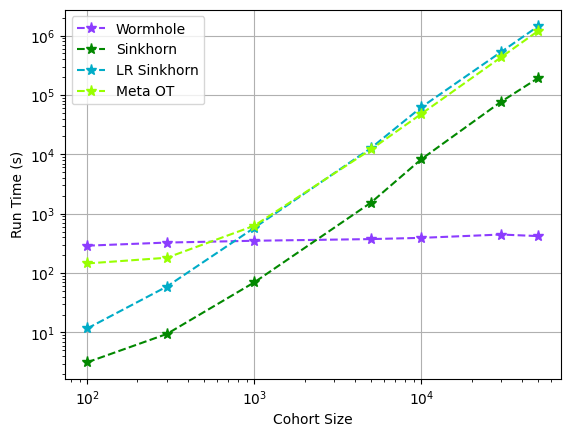

In [46]:
palette = {'Wormhole': matplotlib.cm.get_cmap('cet_glasbey')(1),
           'Sinkhorn': matplotlib.cm.get_cmap('cet_glasbey')(2),
           'LR Sinkhorn': matplotlib.cm.get_cmap('cet_glasbey')(3),
           'Meta OT': matplotlib.cm.get_cmap('cet_glasbey')(4)}

for name, time in zip(['Wormhole', 'Sinkhorn', 'LR Sinkhorn', 'Meta OT'],
                         [wormhole_times, sinkhorn_times, sinkhorn_lr_times,meta_ot_times]):
    
    time = np.asarray(time)
    plt.plot(np.asarray(scale_sizes), time, label = name, marker = '*', linestyle = '--', markersize = 8, c= palette[name])
    plt.xscale('log')
    plt.yscale('log')

plt.xlabel('Cohort Size', fontdict={'size':10})
plt.ylabel('Run Time (s)', fontdict={'size':10})
plt.legend()
plt.grid()
plt.show()